In [1]:
from pyspark.sql import SparkSession

# Initialize Spark
spark = SparkSession.builder \
    .appName("BikeSharingEDA") \
    .getOrCreate()

# Load datasets
hour_df = spark.read.csv("data/hour.csv", header=True, inferSchema=True)
day_df = spark.read.csv("data/day.csv", header=True, inferSchema=True)

# Show sample
hour_df.show(5)
day_df.show(5)


+-------+----------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+
|instant|    dteday|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed|casual|registered|cnt|
+-------+----------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+
|      1|2011-01-01|     1|  0|   1|  0|      0|      6|         0|         1|0.24|0.2879|0.81|      0.0|     3|        13| 16|
|      2|2011-01-01|     1|  0|   1|  1|      0|      6|         0|         1|0.22|0.2727| 0.8|      0.0|     8|        32| 40|
|      3|2011-01-01|     1|  0|   1|  2|      0|      6|         0|         1|0.22|0.2727| 0.8|      0.0|     5|        27| 32|
|      4|2011-01-01|     1|  0|   1|  3|      0|      6|         0|         1|0.24|0.2879|0.75|      0.0|     3|        10| 13|
|      5|2011-01-01|     1|  0|   1|  4|      0|      6|         0|         1|0.24|0.2879|0.75|      0.0

root
 |-- instant: integer (nullable = true)
 |-- dteday: date (nullable = true)
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- hr: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- cnt: integer (nullable = true)

Hour records: 17379
Day records: 731
+-------+------+------+---+----+---+-------+-------+----------+----------+----+-----+---+---------+------+----------+---+
|instant|dteday|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp|atemp|hum|windspeed|casual|registered|cnt|
+-------+------+------+---+----+---+-------+-------+------

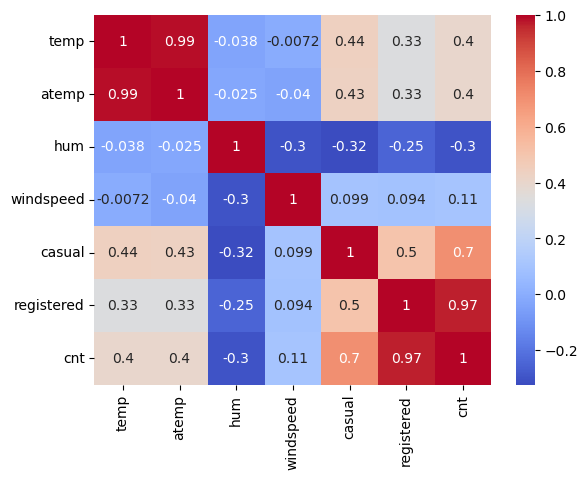

In [2]:
# Columns and types
hour_df.printSchema()

# Count rows
print("Hour records:", hour_df.count())
print("Day records:", day_df.count())

# Check for nulls
from pyspark.sql.functions import col, sum as _sum
hour_df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in hour_df.columns]).show()

# Basic stats
hour_df.describe(["temp", "atemp", "hum", "windspeed", "cnt"]).show()

# Distribution of season, weathersit
hour_df.groupBy("season").count().show()
hour_df.groupBy("weathersit").count().show()

# Correlation matrix (requires converting to pandas)
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
sample = hour_df.select(num_cols).sample(False, 0.1).toPandas()
sns.heatmap(sample.corr(), annot=True, cmap='coolwarm')
plt.show()


In [3]:
day_df_small = day_df.select("dteday", "cnt").withColumnRenamed("cnt", "cnt_daily")
joined_df = hour_df.join(day_df_small, on="dteday", how="left")

# Sanity check
joined_df.select("dteday", "hr", "cnt", "cnt_daily").show(5)


+----------+---+---+---------+
|    dteday| hr|cnt|cnt_daily|
+----------+---+---+---------+
|2011-01-01|  0| 16|      985|
|2011-01-01|  1| 40|      985|
|2011-01-01|  2| 32|      985|
|2011-01-01|  3| 13|      985|
|2011-01-01|  4|  1|      985|
+----------+---+---+---------+
only showing top 5 rows



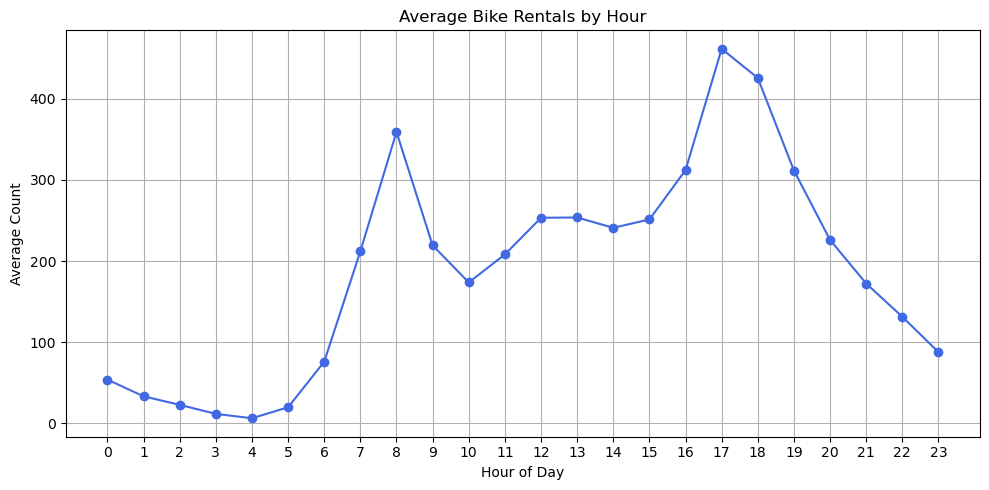

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to Pandas for easier groupby
df_hour = hour_df.toPandas()

hourly_avg = df_hour.groupby('hr')['cnt'].mean()

plt.figure(figsize=(10, 5))
plt.plot(hourly_avg, marker='o', linestyle='-', color='royalblue')
plt.title('Average Bike Rentals by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Count')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


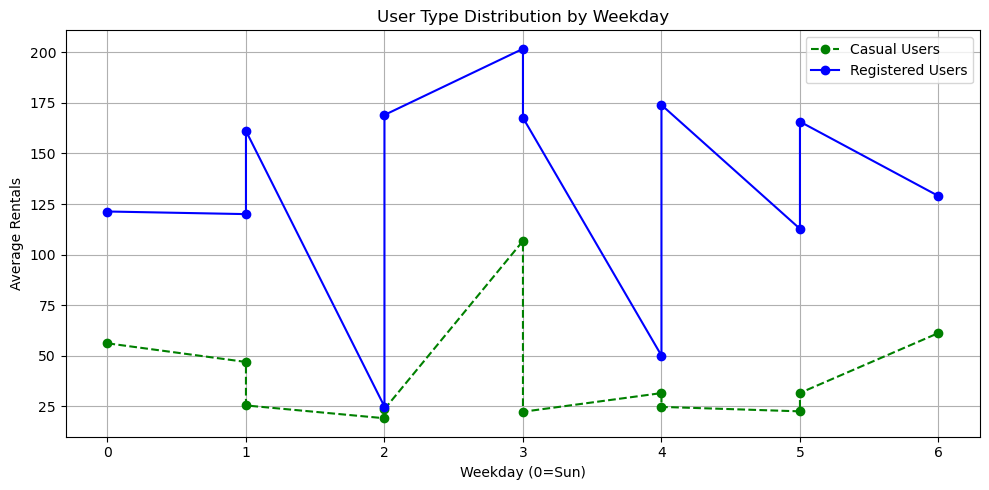

In [6]:
weekday_avg = df_hour.groupby(['weekday', 'workingday'])[['casual', 'registered']].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(weekday_avg['weekday'], weekday_avg['casual'], label='Casual Users', marker='o', linestyle='--', color='green')
plt.plot(weekday_avg['weekday'], weekday_avg['registered'], label='Registered Users', marker='o', color='blue')
plt.title('User Type Distribution by Weekday')
plt.xlabel('Weekday (0=Sun)')
plt.ylabel('Average Rentals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


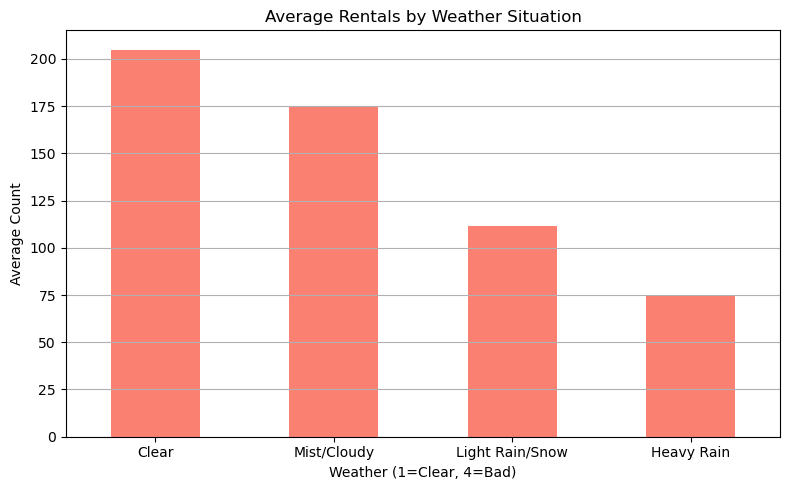

In [8]:
weather_avg = df_hour.groupby('weathersit')['cnt'].mean()

plt.figure(figsize=(8, 5))
weather_avg.plot(kind='bar', color='salmon')
plt.title('Average Rentals by Weather Situation')
plt.xlabel('Weather (1=Clear, 4=Bad)')
plt.ylabel('Average Count')
plt.xticks(ticks=[0,1,2,3], labels=['Clear', 'Mist/Cloudy', 'Light Rain/Snow', 'Heavy Rain'], rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [5]:
joined_df.write.mode("overwrite").parquet("data/joined_bike_data.parquet")
